<a href="https://colab.research.google.com/github/Canihelpme/DeepLearning_finance/blob/main/LSTM_Kospi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from pathlib import Path

folder = ""
project_dir = ""

base_path = Path("/content/drive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/My Drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Input, RepeatVector, TimeDistributed, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
filename = '/content/drive/MyDrive/Financial_data/Data/train/kospi_train_data.csv'
data = pd.read_csv(filename, sep=",",encoding='UTF-8')
data.head()

,Date,End,Open,High,Low,Amount,Val
0,2020년 02월 21일,"2,162.84","2,165.65","2,184.43","2,160.28",635.47M,-1.49%
1,2020년 02월 20일,"2,195.50","2,223.55","2,228.18","2,186.72",709.56M,-0.67%
2,2020년 02월 19일,"2,210.34","2,222.51","2,226.00","2,191.20",591.16M,0.07%
3,2020년 02월 18일,"2,208.88","2,225.98","2,232.93","2,205.21",470.42M,-1.48%
4,2020년 02월 17일,"2,242.17","2,243.07","2,250.05","2,230.26",458.25M,-0.06%


In [ ]:
date_index = data
date_index = date_index.copy()

In [ ]:
date_index['Date'] = date_index.Date.apply(str).str.replace("년","").str.replace("월","").str.replace("일","")
date_index['Date'] = date_index.Date.str.replace(" ","")

date_index['Amount'] = date_index.Amount.apply(str).str.replace("B", "0000000").str.replace("M","0000").str.replace("K","0").str.replace(".","")
date_index['Amount'] = date_index.Amount.astype(int)
date_index['Val'] = date_index.Val.apply(str).str.replace("%", "")
date_index['Val'] = date_index.Val.astype(float)
date_index['End'] = date_index.End.apply(str).str.replace(",","").astype(float).round(0)
date_index['Open'] = date_index.Open.apply(str).str.replace(",","").astype(float).round(0)
date_index['High'] = date_index.High.apply(str).str.replace(",","").astype(float).round(0)
date_index['Low'] = date_index.Low.apply(str).str.replace(",","").astype(float).round(0)

date_index = date_index.loc[::-1].reset_index(drop=True)
date_time = pd.to_datetime(date_index.pop('Date'))
date_index.tail()


,End,Open,High,Low,Amount,Val
10383,2242.0,2243.0,2250.0,2230.0,458250000,-0.06
10384,2209.0,2226.0,2233.0,2205.0,470420000,-1.48
10385,2210.0,2223.0,2226.0,2191.0,591160000,0.07
10386,2196.0,2224.0,2228.0,2187.0,709560000,-0.67
10387,2163.0,2166.0,2184.0,2160.0,635470000,-1.49


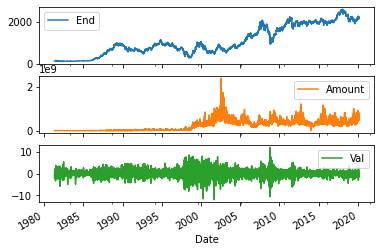

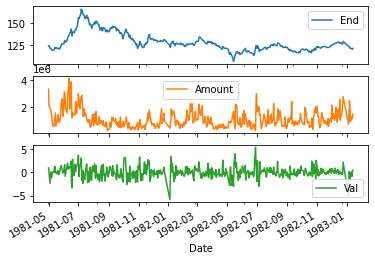

In [ ]:
plot_cols = ['End', 'Amount', 'Val']
plot_features = date_index[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)
#전체적인 데이터 출력
plot_features = date_index[plot_cols][:500]
plot_features.index = date_time[:500]
_ = plot_features.plot(subplots=True)
#데이터의 일부분만 출력하여 데이터의 특성을 추출
#Val, Amount의 경우 가끔 Shooting이 일어나는 값을 제외하고 일정한 범위내에 존재 함

In [ ]:
print(date_index)

          End    Open    High     Low     Amount   Val
0       124.0   124.0   124.0   124.0    3330000  0.98
1       124.0   124.0   124.0   124.0    2040000 -0.08
2       121.0   121.0   121.0   121.0    1930000 -2.35
3       121.0   121.0   121.0   121.0    1690000  0.08
4       119.0   119.0   119.0   119.0    1480000 -1.16
...       ...     ...     ...     ...        ...   ...
10383  2242.0  2243.0  2250.0  2230.0  458250000 -0.06
10384  2209.0  2226.0  2233.0  2205.0  470420000 -1.48
10385  2210.0  2223.0  2226.0  2191.0  591160000  0.07
10386  2196.0  2224.0  2228.0  2187.0  709560000 -0.67
10387  2163.0  2166.0  2184.0  2160.0  635470000 -1.49

[10388 rows x 6 columns]


In [ ]:
date_index.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
End,10388.0,1.028213e+03,6.837746e+02,106.00,5.650000e+02,8.475000e+02,1.721000e+03,2.598000e+03
Open,10388.0,1.028630e+03,6.842217e+02,106.00,5.650000e+02,8.480000e+02,1.721250e+03,2.590000e+03
High,10388.0,1.033877e+03,6.871588e+02,106.00,5.700000e+02,8.535000e+02,1.733000e+03,2.607000e+03
Low,10388.0,1.022228e+03,6.799888e+02,106.00,5.587500e+02,8.410000e+02,1.708000e+03,2.588000e+03
Amount,10388.0,2.175911e+08,2.371764e+08,166000.00,1.038000e+07,1.765450e+08,3.758325e+08,2.380000e+09
Val,10388.0,3.856758e-02,1.457766e+00,-12.02,-6.225000e-01,3.000000e-02,7.125000e-01,1.195000e+01


In [ ]:
column_indices = {name: i for i, name in enumerate(date_index.columns)}

n = len(date_index)
train_df = date_index[0:int(n*0.7)]
val_df = date_index[int(n*0.7):int(n*0.9)]
test_df = date_index[int(n*0.9):]

num_features = date_index.shape[1]

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

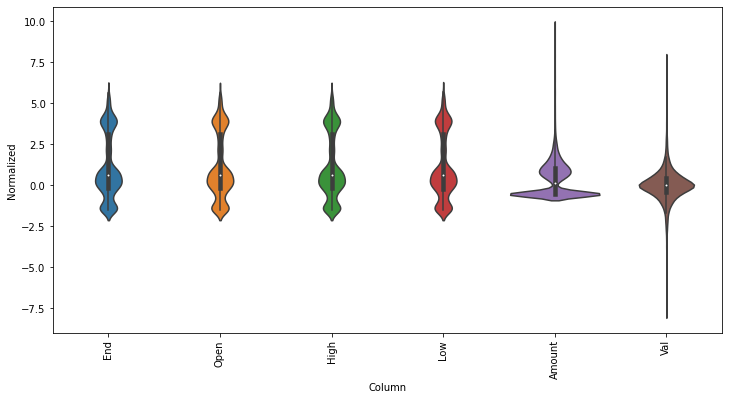

In [ ]:
df_std = (date_index - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(date_index.keys(), rotation=90)

In [ ]:
class WindowGenerator():
   def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df,label_columns=None):
     #Store the raw data.
     self.train_df = train_df
     self.val_df = val_df
     self.test_df = test_df

     self.label_columns = label_columns
     if label_columns is not None:
       self.label_columns_indicies = {name: i for i, name in enumerate(label_columns)}
       self.column_indices = {name:i for i, name in enumerate(train_df.columns)}

    #Work out the window parameters
     self.input_width = input_width
     self.label_width = label_width
     self.shift = shift

     self.total_window_size = input_width + shift

     self.input_slice = slice(0, input_width)
     self.input_indices = np.arange(self.total_window_size)[self.input_slice]

     self.label_start = self.total_window_size - self.label_width
     self.labels_slice = slice(self.label_start, None)
     self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

   def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['End'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['End']

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['End'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['End']

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 6)
Inputs shape: (3, 6, 6)
labels shape: (3, 1, 1)


In [ ]:
w2.example = example_inputs, example_labels